In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
from astropy.stats import LombScargle
from astropy.stats import sigma_clip
from scipy.stats import mode
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.linalg import lstsq
from astropy.io import fits
import astropy.units as u
import h5py
from scipy.interpolate import griddata
# from echelle import plot_echelle, interact_echelle
#import plotutils

import lightkurve as lk
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve
from lightkurve.utils import plot_image

from halophot.halo_tools import halo_tpf

from lightkurve import MPLSTYLE

In [2]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=22              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [3]:
target = "iot Dra"

In [4]:
# search = lk.search_targetpixelfile(target)

In [5]:
# search

In [6]:
tpf = lk.open('/Users/benjaminpope/Dropbox/iot_Dra/iotDra_Sector15.fits.gz')

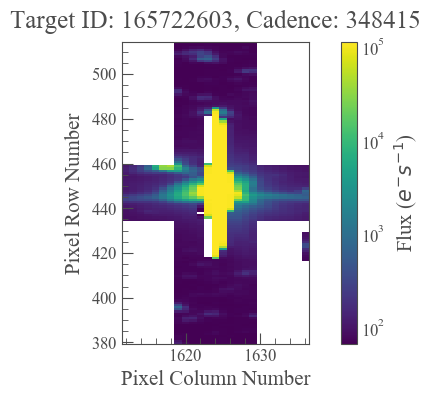

In [7]:
tpf.plot(scale='log',bkg=True,aspect=0.3);

In [8]:
tpf.shape

(17848, 135, 25)

In [9]:
fname = '/Users/benjaminpope/Dropbox/iot_Dra/iotDra_Sector15.fits.gz'

In [10]:
tpf = halo_tpf(fname)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/targetpixelfile.py:1190: LightkurveWarning: A TESS data product is being opened using the `KeplerTargetPixelFile` class. Please use `TessTargetPixelFile` instead.
  LightkurveWarning)


In [11]:
oldbks = tpf.flux_bkg

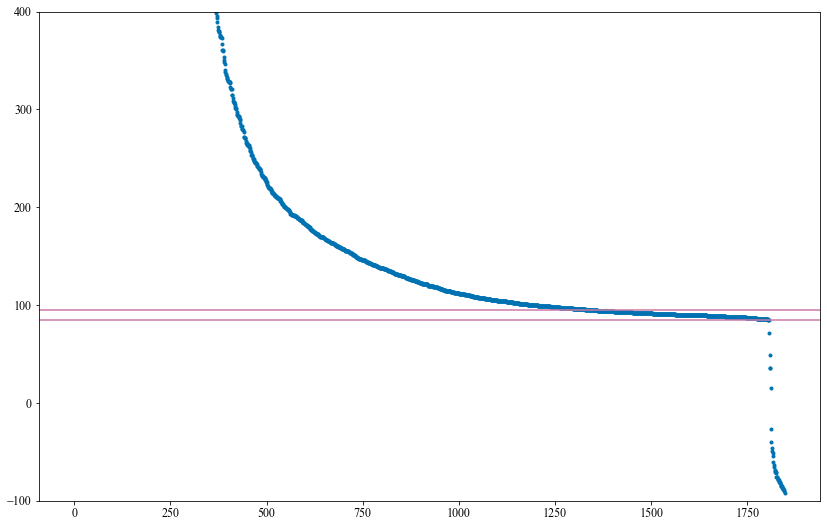

In [12]:
fig = plt.figure(figsize=(14,9))
plt.plot(np.ravel(np.nanmedian(tpf.flux+tpf.flux_bkg, axis=0))[(-np.nanmedian(tpf.flux+tpf.flux_bkg,axis=0)).argsort(axis=None)],'.')
plt.axhline(95,c='C3')
plt.axhline(85,c='C3')
# plt.xlim([0,1500])
plt.ylim([-100,4e2])

plt.show() 

In [13]:
newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')

newmask[np.isnan(np.nanmedian(tpf.flux+tpf.flux_bkg,axis=0))] = False
newmask[np.nanmedian(tpf.flux+tpf.flux_bkg,axis=0) > 95] = False
newmask[np.nanmedian(tpf.flux+tpf.flux_bkg,axis=0) < 85] = False

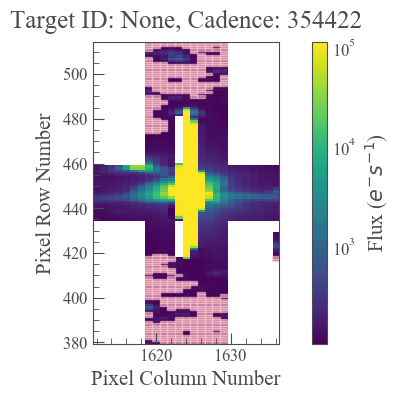

In [14]:
tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = newmask)
plt.show()

In [15]:
zz = np.nanmedian((tpf.flux[:,newmask]+tpf.flux_bkg[:,newmask]),axis=0)
z = (tpf.flux[:,newmask]+tpf.flux_bkg[:,newmask])

z=z[:,np.isfinite(zz)].T
x,y = np.meshgrid(np.arange(tpf.shape[1]), np.arange(tpf.shape[2]))
x=x.T[newmask].flatten()[np.isfinite(zz)]
y=y.T[newmask].flatten()[np.isfinite(zz)]

ind = np.isfinite(np.sum(z,axis=0))

# M = np.c_[x,y,np.ones(x.shape[0])]
# p = np.zeros((3,tpf.shape[0]))
# p[:,ind], _, _, _ = lstsq(M, z[:,ind])

M = np.c_[x*y,x,y,np.ones(x.shape[0])]
p = np.zeros((4,tpf.shape[0]))
p[:,ind], _, _, _ = lstsq(M, z[:,ind])

In [16]:
x = np.tile(np.expand_dims(np.tile(np.expand_dims(np.arange(tpf.shape[1]),axis=1),tpf.shape[0]).T,axis=2),tpf.shape[2])
y = np.tile(np.expand_dims(np.tile(np.expand_dims(np.arange(tpf.shape[2]),axis=1),tpf.shape[1]),axis=2),tpf.shape[0]).T
c = np.tile(np.expand_dims(np.tile(np.expand_dims(p,axis=2),tpf.shape[1]),axis=3),tpf.shape[2])

In [17]:
tiltbks_xy_x_y = c[0,:,:,:]*x*y + c[1,:,:,:]*x + c[2,:,:,:]*y + c[3,:,:,:]

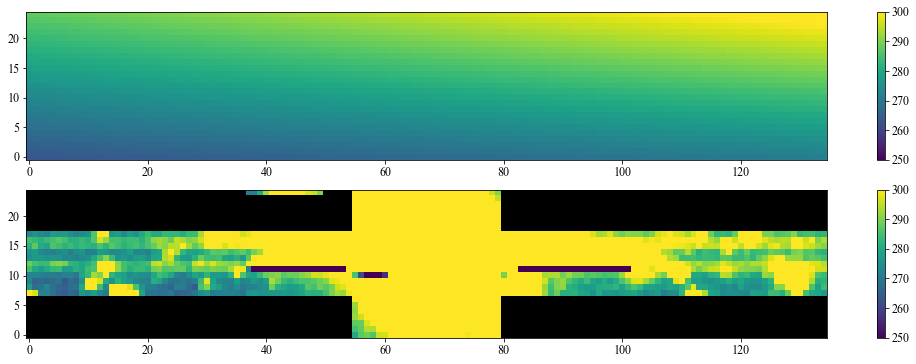

In [18]:
fig,axes = plt.subplots(2,1,figsize=(18,6))

xl=-0.5,134.5
asp = 1
frame = 8250
cmax = 300
cmin = 250

cmap = mpl.cm.viridis
# norm = np.size(newmask)
cmap.set_bad('k',1.)
im = ((tiltbks_xy_x_y[frame,:,:]).T)
# plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
#     interpolation='None',origin='lower')
img = axes[0].imshow(im,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
axes[0].set_xlim(xl)
plt.colorbar(img, ax=axes[0])

im2 = (((tpf.flux[frame,:,:]+tpf.flux_bkg[frame,:,:])).T)
# plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
#     interpolation='None',origin='lower')
img = axes[1].imshow(im2,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
axes[1].set_xlim(xl)
plt.colorbar(img, ax=axes[1])

plt.show()

In [19]:
tpf.flux_bkg.shape

(17942, 135, 25)

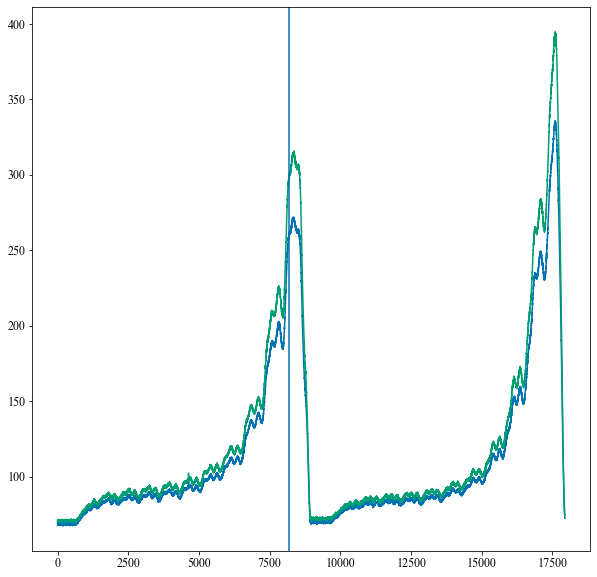

In [20]:
plt.plot(np.nanmin(np.nanmin(tiltbks_xy_x_y,axis=1),axis=1))
plt.plot(np.nanmax(np.nanmax(tiltbks_xy_x_y,axis=1),axis=1))
plt.axvline(8200)
plt.show()

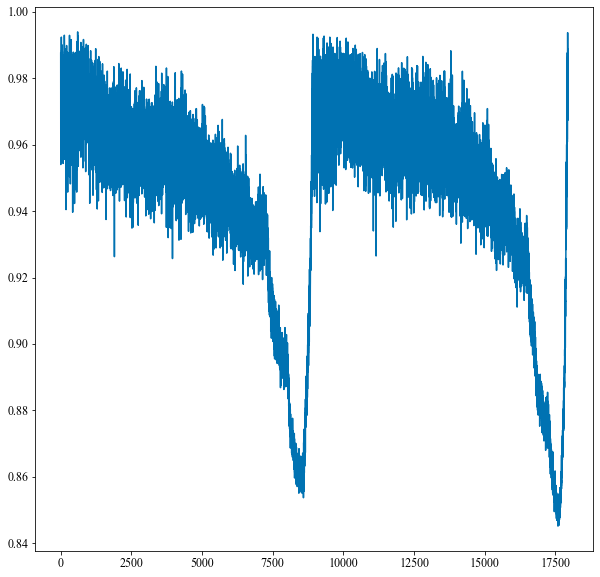

In [21]:
plt.plot(np.nanmin(np.nanmin(tiltbks_xy_x_y,axis=1),axis=1)/np.nanmax(np.nanmax(tiltbks_xy_x_y,axis=1),axis=1))
plt.show()

In [28]:
tpf.__class__ = halophot.halo_tools.halo_tpf_tess

tpf.flux = tpf.flux + tpf.flux_bkg - tiltbks_xy_x_y
tpf.flux_bkg = tiltbks_xy_x_y

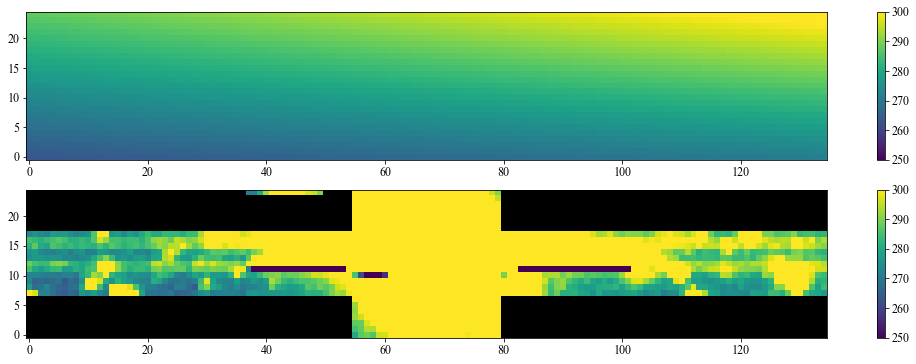

In [30]:
fig,axes = plt.subplots(2,1,figsize=(18,6))

xl=-0.5,134.5
asp = 1
frame = 8250
cmax = 300
cmin = 250

cmap = mpl.cm.viridis
# norm = np.size(newmask)
cmap.set_bad('k',1.)
im = ((tpf.flux_bkg[frame,:,:]).T)
# plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
#     interpolation='None',origin='lower')
img = axes[0].imshow(im,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
axes[0].set_xlim(xl)
plt.colorbar(img, ax=axes[0])

im2 = (((tpf.flux[frame,:,:]+tpf.flux_bkg[frame,:,:])).T)
# plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
#     interpolation='None',origin='lower')
img = axes[1].imshow(im2,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
axes[1].set_xlim(xl)
plt.colorbar(img, ax=axes[1])

plt.show()

In [42]:
from scipy.ndimage.morphology import binary_dilation

In [57]:
sapmask = tpf.create_threshold_mask(threshold=50)
sapmask = binary_dilation(sapmask)
sapmask = binary_dilation(sapmask)

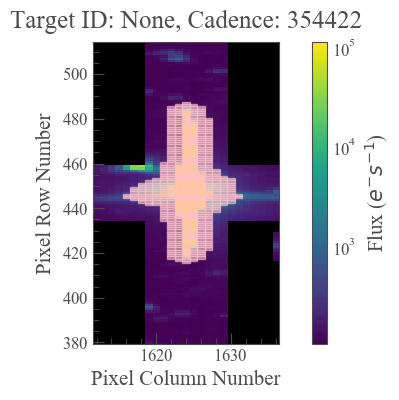

In [58]:
tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = sapmask)
plt.show()

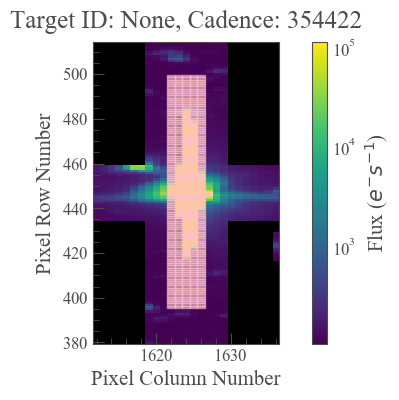

In [33]:
# tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = tpf.pipeline_mask)
# plt.show()

In [59]:
lc = tpf.extract_aperture_photometry(aperture_mask=sapmask)
# lc2 = tpf.extract_aperture_photometry(aperture_mask=tpf.pipeline_mask)

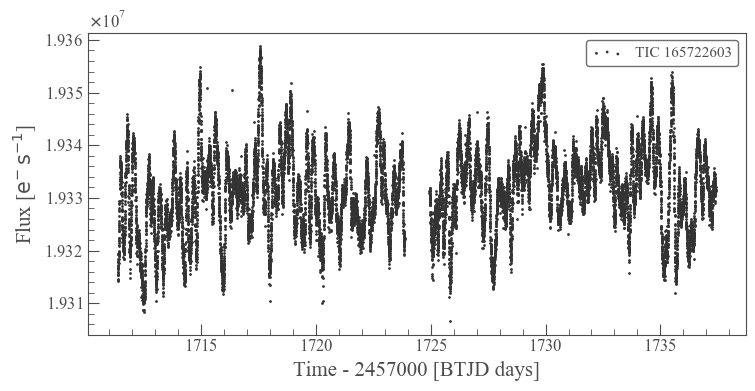

In [60]:
lc.scatter()

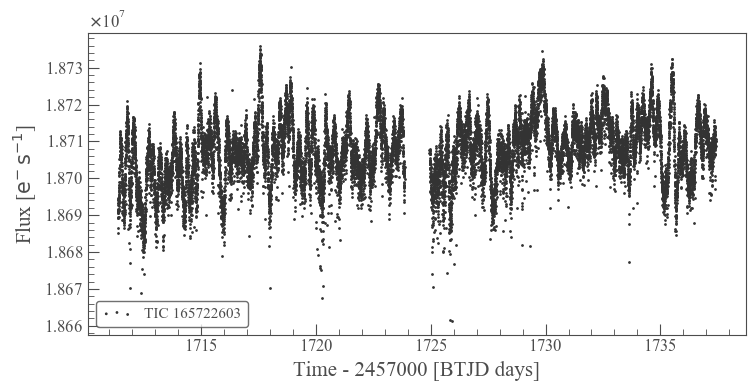

In [52]:
lc2.scatter()

In [36]:
tpf.interact(aperture_mask=sapmask)

In [37]:
tpf.to_fits(output_fn='iotDra_Sector15.fits')

In [38]:
fname = 'iotDra_Sector15.fits.gz' 

In [39]:
tpf = halo_tpf(fname)

FileNotFoundError: [Errno 2] No such file or directory: 'iotDra_Sector15.fits.gz'

In [ ]:
tpf.plot(aspect=0.3,scale='log',bkg=True);

In [ ]:
sapmask = tpf.create_threshold_mask(threshold=10,method='max')

In [ ]:
tpf2 = search[1].download()

In [ ]:
lk.__version__